In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/tmp/ipykernel_30/3717255228.py:62: UserWarning:

[W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.




Analyse du réseau:
Nombre de nœuds: 27
Nombre d'arêtes: 113

Nœuds les plus centraux:
machine: 0.654
learning: 0.615
intelligence: 0.500
vision: 0.500
experience: 0.500


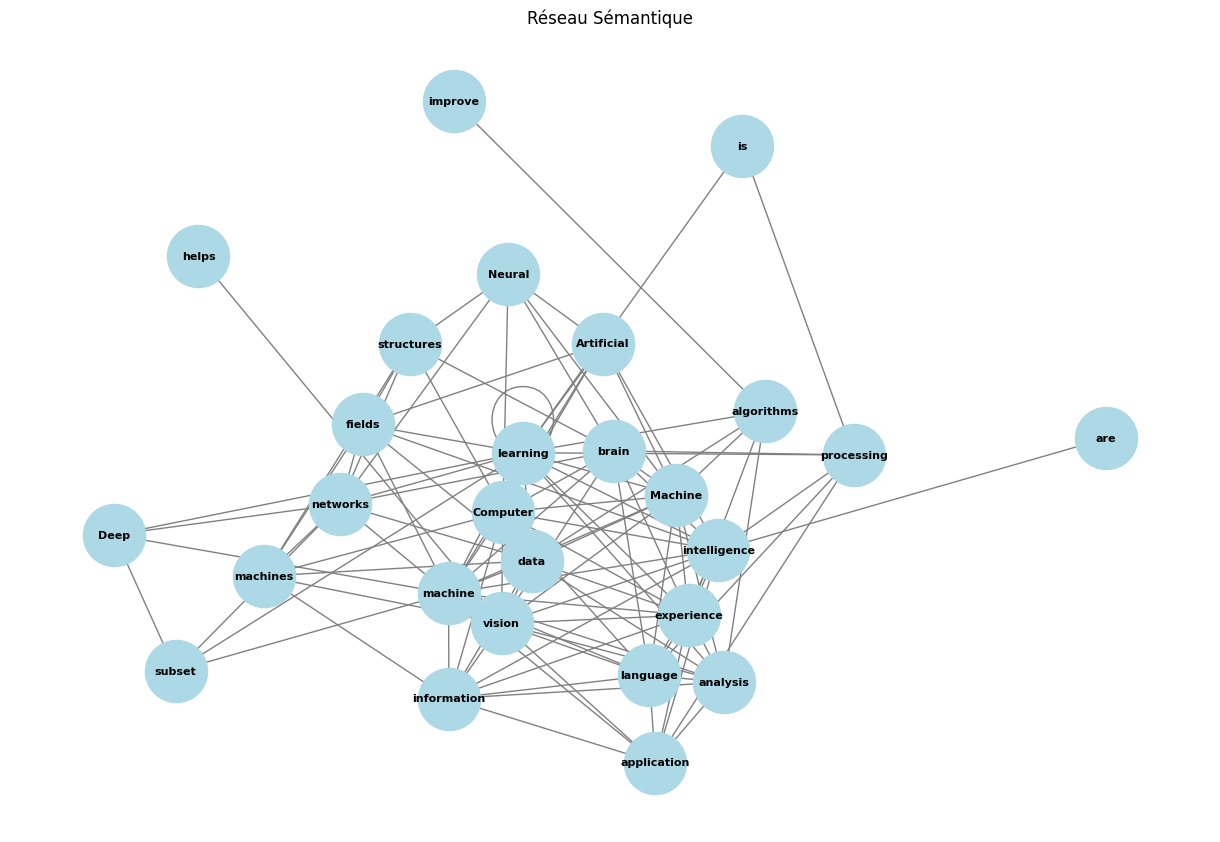

In [8]:
# TP2 : Les réseaux sémantiques
# MAROUANE BOUFAROUJ - IID3
# ENSA Khouribga - Ingénierie des Connaissances 


import spacy
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
from dash import Dash, html
import dash_cytoscape as cyto


nlp = spacy.load("en_core_web_sm")
text = """
Artificial intelligence and machine learning are closely related fields.
Deep learning is a subset of machine learning that uses neural networks.
Natural language processing is a key application of artificial intelligence.
Computer vision helps machines interpret and understand visual information.
Machine learning algorithms improve through experience and data analysis.
Neural networks are inspired by biological brain structures.
"""

doc = nlp(text)
entities = []
relations = []

for sentence in doc.sents:
    # Entités et mots-clés importants
    ents = [token.text for token in sentence 
            if (token.ent_type_ or token.pos_ in ['NOUN', 'PROPN']) 
            and not token.is_stop]
    entities.extend(ents)
    
    # Relations par co-occurrence et syntaxe
    for ent1, ent2 in combinations(ents, 2):
        relations.append((ent1, ent2))
    # Relations syntaxiques supplémentaires
    for token in sentence:
        if token.dep_ == "ROOT":
            for child in token.children:
                if child.dep_ in ["nsubj", "dobj"]:
                    relations.append((token.text, child.text))

# Nettoyage des doublons
entities = list(set(entities))
relations = list(set(relations))

# Similarité sémantique
for ent1 in entities:
    for ent2 in entities:
        if ent1 != ent2:
            similarity = nlp(ent1).similarity(nlp(ent2))
            if similarity > 0.6: 
                relations.append((ent1, ent2))


G = nx.Graph()
G.add_nodes_from(entities)
G.add_edges_from(relations)

print("\nAnalyse du réseau:")
print(f"Nombre de nœuds: {G.number_of_nodes()}")
print(f"Nombre d'arêtes: {G.number_of_edges()}")
print("\nNœuds les plus centraux:")
for node, cent in sorted(nx.degree_centrality(G).items(), 
                        key=lambda x: x[1], reverse=True)[:5]:
    print(f"{node}: {cent:.3f}")

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=1, iterations=50)

nx.draw(G, pos,
        node_color='lightblue',
        node_size=2000,
        with_labels=True,
        font_size=8,
        font_weight='bold',
        edge_color='gray',
        width=1)

plt.title("Réseau Sémantique")
plt.show()

app = Dash(__name__)

app.layout = html.Div([
    html.H1('Visualisation du Réseau Sémantique'),
    cyto.Cytoscape(
        id='réseau-sémantique',
        elements=[
            {'data': {'id': n, 'label': n}} for n in G.nodes()
        ] + [
            {'data': {'source': s, 'target': t}} for (s, t) in G.edges()
        ],
        layout={'name': 'cose'},
        style={'width': '100%', 'height': '600px'},
        stylesheet=[
            {
                'selector': 'node',
                'style': {
                    'content': 'data(label)',
                    'background-color': '#88CCEE',
                    'text-wrap': 'wrap',
                    'font-size': '12px'
                }
            },
            {
                'selector': 'edge',
                'style': {
                    'curve-style': 'bezier',
                    'opacity': 0.7
                }
            }
        ]
    )
])

if __name__ == '__main__':
    # Démarrer le serveur Dash
    app.run_server(debug=True)
